In [1]:
import torch
import xgboost as xgb
import pandas as pd
import shap
import matplotlib.pyplot as plt
import mlflow
from IPython.display import IFrame
from sklearn.metrics import (  # type: ignore
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

from src.data.data_spliter import DataSplitter
from src.data.data_utils import (
    find_first_positive,
    find_last_positive,
    load_data,
    merge_multiple_dataframes,
    validate_no_label_leakage,
    compare_timestamps,
)
from src.models.datasets import LSTMFailureDataset, XGBoostFailureDataset, generate_flat_feature_names
from src.models.lstm import LSTMNetwork
from src.transformations.features import (
    add_time_since_last_event_features,
    encode_machine_model,
    encode_time,
)

### Constants

In [2]:
ignored_columns = [
    "errorID", "failure", "maint_comp1", "maint_comp2", "maint_comp3", "maint_comp4",
    "failure_comp1", "failure_comp2", "failure_comp3", "failure_comp4",
    "code_error1", "code_error2", "code_error3", "code_error4", "code_error5", "model",
]
HORIZON = 24
drop_cols = ["datetime", "machineID"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###  Data Loading and Preprocessing

In [3]:
dfs = load_data()
final_df = merge_multiple_dataframes(dfs)
final_df = add_time_since_last_event_features(final_df)
final_df = encode_time(final_df)
final_df = encode_machine_model(final_df)

###  Train/Val/Test Split

In [4]:
splitter = DataSplitter(
    seq_len=25,
    horizon=HORIZON,
    random_state=42,
    ignore_columns=ignored_columns,
    split_by_time=True,
    enable_scaling=True,
)
train_split, val_split, test_split = splitter.create_splits(final_df)


### Data Leakage Validation 

In [5]:
print('Chek labels are as expected in a case') 
if first_positive := find_first_positive(train_split):
    validate_no_label_leakage(first_positive[0], dfs["PdM_failures"], horizon=HORIZON)

if last_positive := find_last_positive(train_split):
    validate_no_label_leakage(last_positive[0], dfs["PdM_failures"], horizon=HORIZON)
print('Compare timestamps in train and val splits')
compare_timestamps(train_split, val_split)

Chek labels are as expected in a case
✅ No data leakage detected.
✅ Expected failure found at: 2015-03-06 06:00:00
✅ No data leakage detected.
✅ Expected failure found at: 2015-02-12 06:00:00
Compare timestamps in train and val splits
📅 Earliest timestamp in train: 2015-01-02 05:00:00
📅 Latest timestamp in train: 2015-08-07 05:00:00
📅 Earliest timestamp in validation: 2015-08-09 05:00:00
📅 Latest timestamp in validation: 2015-10-19 06:00:00
Is there any time leakage: False


### LSTM Model Training and Evaluation

In [6]:
train_dataset = LSTMFailureDataset(train_split, drop_cols=drop_cols)
val_dataset = LSTMFailureDataset(val_split, drop_cols=drop_cols)
test_dataset = LSTMFailureDataset(test_split, drop_cols=drop_cols)

input_dim = train_split[0][0].shape[1] - len(drop_cols)

lstm = LSTMNetwork(
    input_dim=input_dim,
    device=device,
    hidden_size=128,
    num_layers=2,
    num_classes=2,
    dropout=0.3,
)

lstm.fit(train_dataset=train_dataset, val_dataset=val_dataset)

result = lstm.evaluate(test_dataset=test_dataset, return_confusion_matrix=True)

if len(result) == 3:
    avg_loss, accuracy, conf_matrix = result
    tn, fp, fn, tp = conf_matrix.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    print("LSTM Evaluation:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall:   {recall:.4f}")
    print(f"Precision:{precision:.4f}")

run = lstm.get_run()

Training:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 7/14 [00:00<00:00, 66.06it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  10%|███████████████████▎                                                                                                                                                                             | 1/10 [00:00<00:02,  4.33it/s]

Epoch 01 | Train Loss: 0.5794, Acc: 0.7667 | Val Loss: 0.3388, Acc: 0.8993



Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 11/14 [00:00<00:00, 100.97it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  20%|██████████████████████████████████████▌                                                                                                                                                          | 2/10 [00:00<00:01,  4.89it/s]

Epoch 02 | Train Loss: 0.1405, Acc: 0.9498 | Val Loss: 0.1314, Acc: 0.9479



Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 11/14 [00:00<00:00, 101.31it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  30%|█████████████████████████████████████████████████████████▉                                                                                                                                       | 3/10 [00:00<00:01,  5.13it/s]

Epoch 03 | Train Loss: 0.0927, Acc: 0.9632 | Val Loss: 0.0962, Acc: 0.9653



Training:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 10/14 [00:00<00:00, 99.39it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 4/10 [00:00<00:01,  5.22it/s]

Epoch 04 | Train Loss: 0.0432, Acc: 0.9844 | Val Loss: 0.0589, Acc: 0.9826



Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 11/14 [00:00<00:00, 101.63it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 5/10 [00:00<00:00,  5.30it/s]

Epoch 05 | Train Loss: 0.0272, Acc: 0.9922 | Val Loss: 0.0531, Acc: 0.9826



Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 11/14 [00:00<00:00, 100.53it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 6/10 [00:01<00:00,  5.34it/s]

Epoch 06 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0403, Acc: 0.9861



Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 11/14 [00:00<00:00, 100.91it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 7/10 [00:01<00:00,  5.36it/s]

Epoch 07 | Train Loss: 0.0132, Acc: 0.9967 | Val Loss: 0.0597, Acc: 0.9826



Training:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 10/14 [00:00<00:00, 99.40it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8/10 [00:01<00:00,  5.36it/s]

Epoch 08 | Train Loss: 0.0126, Acc: 0.9967 | Val Loss: 0.0340, Acc: 0.9896



Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 11/14 [00:00<00:00, 100.38it/s]
                                                                                                                                                                                                                                                      
Training Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9/10 [00:01<00:00,  5.38it/s]

Epoch 09 | Train Loss: 0.0125, Acc: 0.9944 | Val Loss: 0.0538, Acc: 0.9826



Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 11/14 [00:00<00:00, 101.13it/s]
                                                                                                                                                                                                                                                      
Training Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.28it/s]


Epoch 10 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0623, Acc: 0.9826


2025/04/06 13:58:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 13:58:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 13:58:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
                                                                       

LSTM Evaluation:
[[132   5]
 [  1 136]]
Accuracy: 0.9781
Recall:   0.9927
Precision:0.9645


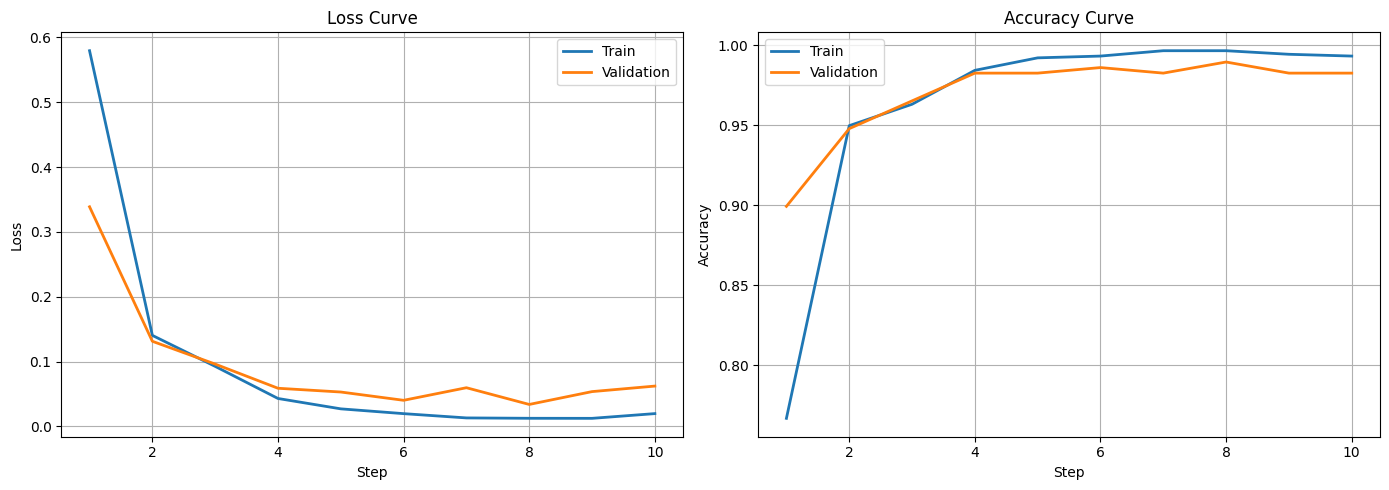

In [7]:
client = mlflow.tracking.MlflowClient()
run_id = run.run_id

def fetch_metric_history(metric_name: str) -> pd.DataFrame:
    """Fetch metric history from MLflow and return as DataFrame."""
    try:
        history = client.get_metric_history(run_id, metric_name)
        return pd.DataFrame([{"step": m.step, "value": m.value} for m in history])
    except Exception as e:
        print(f"Could not fetch '{metric_name}': {e}")
        return pd.DataFrame(columns=["step", "value"])

def plot_metric(ax, train_df, val_df, title, ylabel, labels=("Train", "Validation")):
    """Plot a metric (e.g., loss or accuracy) on the given axis."""
    if not train_df.empty:
        ax.plot(train_df["step"], train_df["value"], label=f"{labels[0]}", linewidth=2)
    if not val_df.empty:
        ax.plot(val_df["step"], val_df["value"], label=f"{labels[1]}", linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

metrics_to_plot = {
    "Loss Curve": ("train_loss", "val_loss"),
    "Accuracy Curve": ("train_accuracy", "val_accuracy"),
}

fig, axs = plt.subplots(1, len(metrics_to_plot), figsize=(7 * len(metrics_to_plot), 5))

# If only one subplot, wrap in list for uniform handling
if len(metrics_to_plot) == 1:
    axs = [axs]

for ax, (title, (train_name, val_name)) in zip(axs, metrics_to_plot.items()):
    train_df = fetch_metric_history(train_name)
    val_df = fetch_metric_history(val_name)
    plot_metric(ax, train_df, val_df, title, ylabel=title.split()[0])

plt.tight_layout()
plt.show()

In [8]:
mlflow_url = "http://localhost:5000"
IFrame(src=mlflow_url, width='100%', height=600)

### XGBoost Training

In [9]:
xgbtrain_dataset = XGBoostFailureDataset(train_split, drop_cols=drop_cols, flatten_method="stack")
X_train, y_train = xgbtrain_dataset.get_data()

xgbtest_dataset = XGBoostFailureDataset(test_split, drop_cols=drop_cols, flatten_method="stack")
X_test, y_test = xgbtest_dataset.get_data()

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [10]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print("\nXGBoost Evaluation Metrics on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


XGBoost Evaluation Metrics on Test Set:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
AUC:       1.0000

Confusion Matrix:
[[137   0]
 [  0 137]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       137
           1     1.0000    1.0000    1.0000       137

    accuracy                         1.0000       274
   macro avg     1.0000    1.0000    1.0000       274
weighted avg     1.0000    1.0000    1.0000       274



### SHAP Explainability

/tmp/ipykernel_1948223/790815716.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


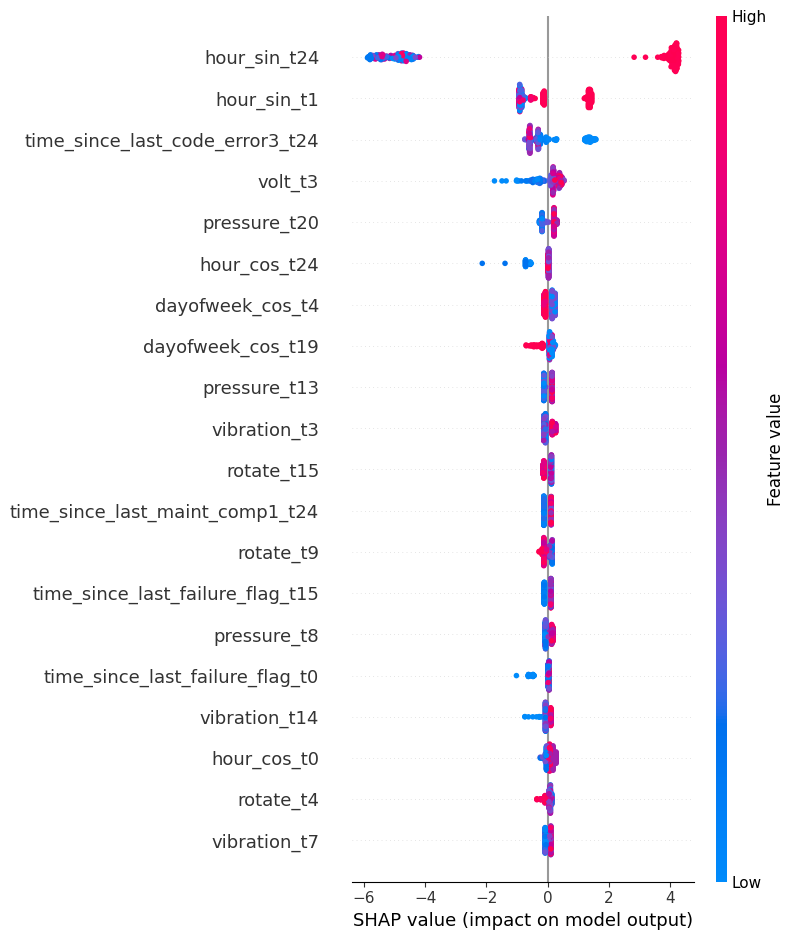

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=generate_flat_feature_names(test_split[0][0], drop_cols)
)

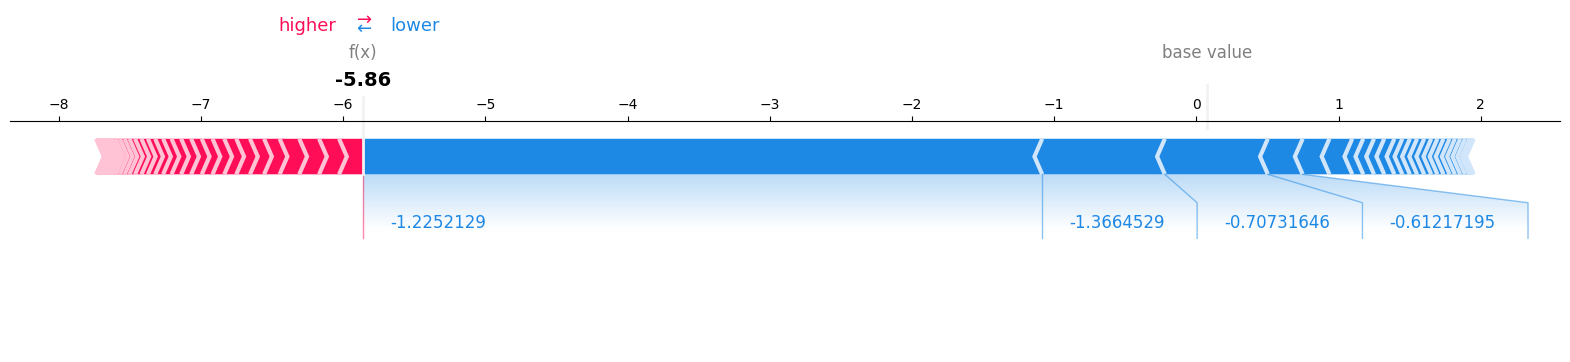

In [12]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], matplotlib=True)

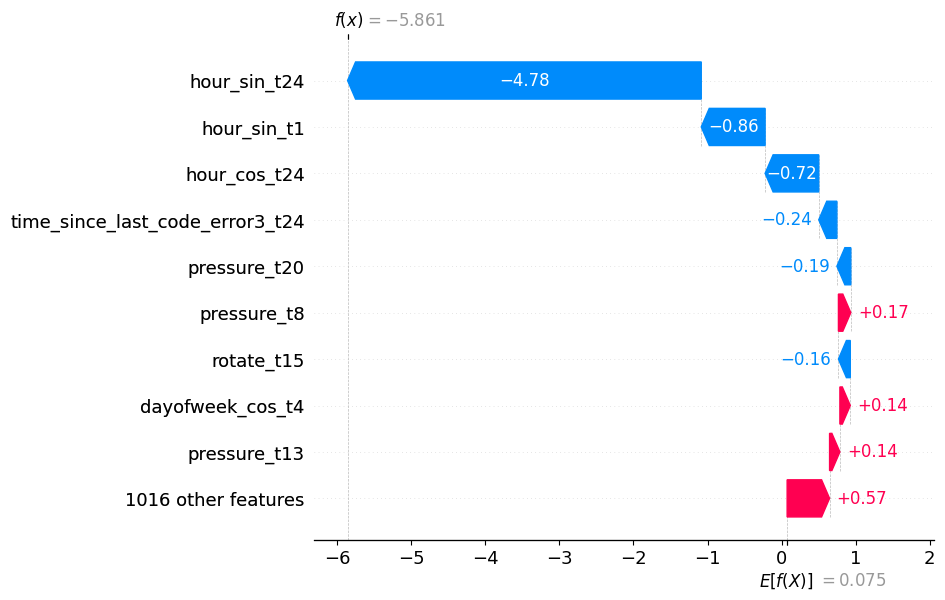

In [13]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
   feature_names=generate_flat_feature_names(test_split[0][0], drop_cols),
)


In [14]:
drop_cols = drop_cols + ['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
xgbtrain_dataset = XGBoostFailureDataset(train_split, drop_cols=drop_cols, flatten_method="stack")
X_train, y_train = xgbtrain_dataset.get_data()

xgbtest_dataset = XGBoostFailureDataset(test_split, drop_cols=drop_cols, flatten_method="stack")
X_test, y_test = xgbtest_dataset.get_data()

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [15]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print("\nXGBoost Evaluation Metrics on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


XGBoost Evaluation Metrics on Test Set:
Accuracy:  0.9672
Precision: 0.9444
Recall:    0.9927
F1 Score:  0.9680
AUC:       0.9975

Confusion Matrix:
[[129   8]
 [  1 136]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9923    0.9416    0.9663       137
           1     0.9444    0.9927    0.9680       137

    accuracy                         0.9672       274
   macro avg     0.9684    0.9672    0.9671       274
weighted avg     0.9684    0.9672    0.9671       274



/tmp/ipykernel_1948223/790815716.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


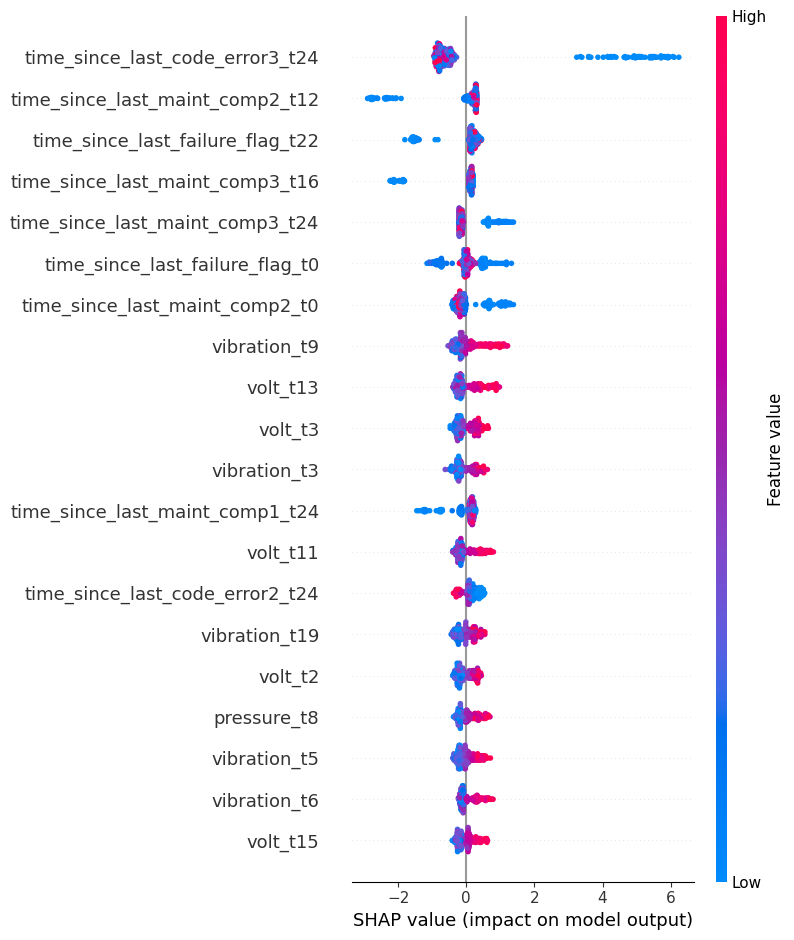

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=generate_flat_feature_names(test_split[0][0], drop_cols)
)

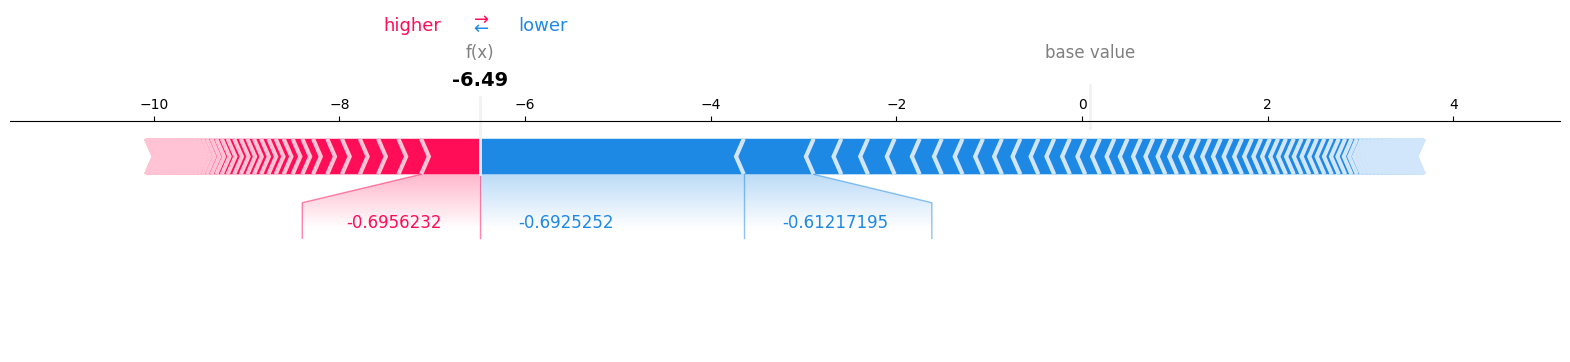

In [17]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], matplotlib=True)

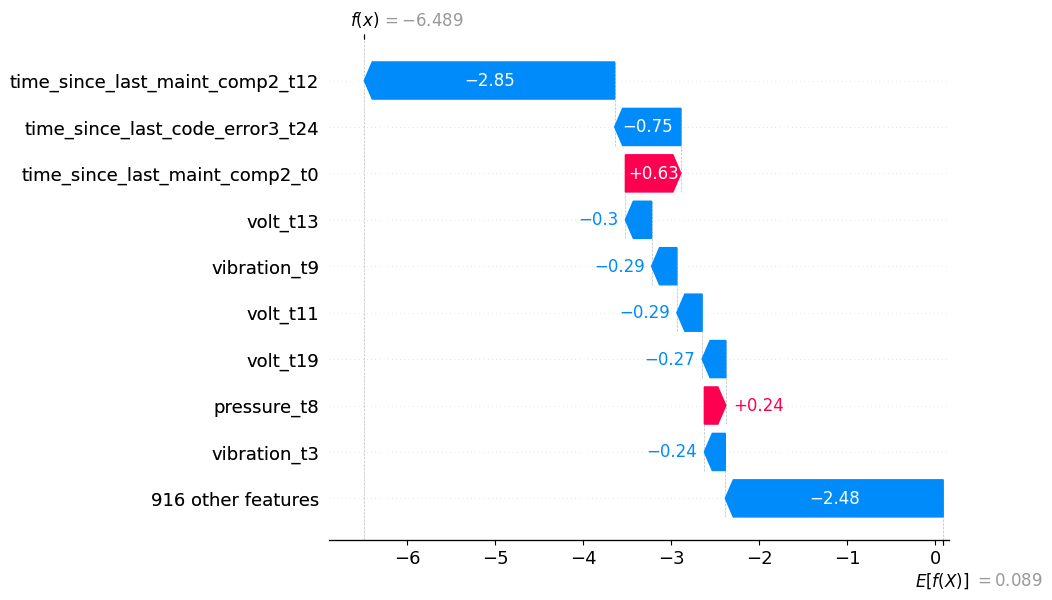

In [18]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
   feature_names=generate_flat_feature_names(test_split[0][0], drop_cols),
)
